<a href="https://colab.research.google.com/github/besherh/BigDataManagement/blob/main/SparkNotebooks/Spark_Streaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up PySpark in Colab
Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.



In [1]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 13 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u282-b08-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u282-b08-0ubuntu1~18.04 [8,267 kB]
Fetched 36.5 MB in 2s (17.5 MB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database

Next, we will install Apache Spark 3.0.1 with Hadoop 2.7 .


In [2]:
!wget https://apache.mirrors.nublue.co.uk/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz


--2021-03-02 08:29:52--  https://apache.mirrors.nublue.co.uk/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
Resolving apache.mirrors.nublue.co.uk (apache.mirrors.nublue.co.uk)... 141.0.161.104, 2a01:61c0:1:10:141:0:161:104
Connecting to apache.mirrors.nublue.co.uk (apache.mirrors.nublue.co.uk)|141.0.161.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220488957 (210M) [application/octet-stream]
Saving to: ‘spark-3.0.2-bin-hadoop2.7.tgz’

spark-3.0.2-bin-had 100%[===================>] 210.27M  8.44MB/s    in 57s     

2021-03-02 08:30:50 (3.66 MB/s) - ‘spark-3.0.2-bin-hadoop2.7.tgz’ saved [220488957/220488957]



Now, we just need to unzip that folder.


In [3]:
!tar xf spark-3.0.2-bin-hadoop2.7.tgz


There is one last thing that we need to install and that is the findspark library. It will locate Spark on the system and import it as a regular library.



In [4]:
!pip install -q findspark


Now that we have installed all the necessary dependencies in Colab, it is time to set the environment path. This will enable us to run Pyspark in the Colab environment.


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"


We need to locate Spark in the system. For that, we import findspark and use the findspark.init() method.

In [6]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.0.2-bin-hadoop2.7'

Now, we can import SparkSession from pyspark.sql and create a SparkSession, which is the entry point to Spark.

You can give a name to the session using appName() and add some configurations with config() if you wish.

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Finally, print the SparkSession variable.

In [8]:
spark


#optional
If you want to view the Spark UI, you would have to include a few more lines of code to create a public URL for the UI page.

In [10]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2021-03-02 08:42:33--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.225.89.236, 52.200.171.63, 34.195.37.70, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.225.89.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  59.1MB/s    in 0.2s    

2021-03-02 08:42:33 (59.1 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://e519c04766ad.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}

#Analyzing Sensor Data with Spark Streaming

By the end of this activity, you will be able to:
1.	Read streaming data into Spark
2.	Create and apply computations over a sliding window of data
Look at sensor format and measurement types:
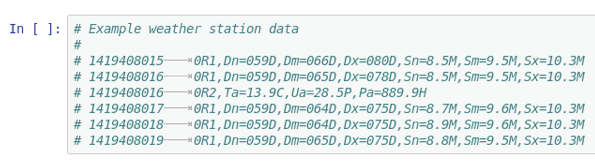
Each line contains a timestamp and a set of measurements. Each measurement has an abbreviation, and for this exercise, we are interested in the average wind direction, which is Dm. The photo  lists the abbreviations used for each type of measurement:
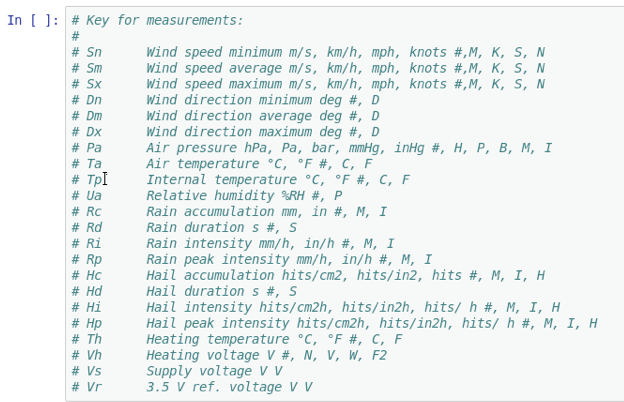

In [11]:
#  a function that parses each line and returns the average wind direction (Dm). Run this cell:
#
import re
def parse(line):
    match = re.search("Dm=(\d+)", line)
    if match:
        val = match.group(1)
        return [int(val)]
    return []

Import and create streaming context. Next, we will import and create a new instance of Spark's StreamingContext.
Similar to the SparkContext, the StreamingContext provides an interface to Spark's streaming capabilities. The argument sc is the SparkContext, and 1 specifies a batch interval of one second.

In [12]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
sc = SparkContext.getOrCreate()
#A batch interval of 1 second.
ssc = StreamingContext(sc,1)

Create DStream of weather data. Let's open a connection to the streaming weather data:

In [13]:
lines = ssc.socketTextStream("rtd.hpwren.ucsd.edu", 12028)

Instead of 12028, you may find that port 12020 works instead. This create a new variable lines to be a Spark DStream that streams the lines of output from the weather station.

. Read measurement. Next, let's read the average wind speed from each line and store it in a new DStream vals:

In [14]:
vals = lines.flatMap(parse)

This line uses flatMap() to iterate over the lines DStream, and calls the parse() function we defined above to get the average wind speed.

Create sliding window of data. We can create a sliding window over the measurements by calling the window() method:

In [15]:
#Creates a window that combines 10 seconds worth of data and moves by 5 seconds.
window = vals.window(10, 5)

This create a new DStream called window that combines the ten seconds worth of data and moves by five seconds.

Define and call analysis function. We would like to find the minimum and maximum values in our window. Let's define a function that prints these values for an RDD:

In [16]:
def stats(rdd):
    print(rdd.collect())
    print(rdd.collect(), file = open('wind_direction_streaming.txt', 'a'))
    if rdd.count() > 0:
        print("max = {}, min = {}".format(rdd.max(), rdd.min()))
        print("max = {}, min = {}".format(rdd.max(), rdd.min()), file = open('wind_direction_streaming.txt', 'a'))


This function first prints the entire contents of the RDD by calling the collect() method. This is done to demonstrate the sliding window and would not be practical if the RDD was containing a large amount of data. Next, we check if the size of the RDD is greater than zero before printing the maximum and minimum values.
Next, we call the stats() function for each RDD in our sliding window:


In [17]:
#open the file for writing
file1 = open('wind_direction_streaming.txt', 'w')


This line calls the stats() function defined above for each RDD in the DStream window.

In [18]:

window.foreachRDD(lambda rdd: stats(rdd))

In [19]:
# Start the stream processing. We call start() on the StreamingContext to begin the processing:
ssc.start()
ssc.awaitTermination()


KeyboardInterrupt: ignored

In [20]:
ssc.stop()


[128, 128, 128]
max = 128, min = 128
